# [DATA LOADING AND PROCESSING TUTORIAL](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

* scikit-image
* pandas


In [1]:
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

%matplotlib inline

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

![68 landmark points](https://pytorch.org/tutorials/_images/landmarked_face2.png)

In [3]:
landmarks_frame = pd.read_csv("../../datasets/faces/face_landmarks.csv")
print(landmarks_frame.sample(10))

n = 65
img_name = landmarks_frame.iloc[n, 0]

landmarks = landmarks_frame.iloc[n, 1 :].as_matrix()
landmarks = landmarks.astype(np.float).reshape(-1, 2)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[: 4]))


                   image_name  part_0_x  part_0_y  part_1_x  part_1_y  \
24  2722779845_7fcb64a096.jpg        71       128        63       151   
14  2322901504_08122b01ba.jpg       195       202       191       219   
20   262007783_943bbcf613.jpg       123       137       128       176   
3    110276240_bec305da91.jpg        42       140        45       161   
30   299733036_fff5ea6f8e.jpg       122       149       121       163   
18                2382SJ8.jpg        50       100        49       112   
51  3718903026_c1bf5dfcf8.jpg       125       220       124       245   
35  3273658251_b95f65c244.jpg       220        85       221       110   
62           britney-bald.jpg        52       134        54       149   
41   348272697_832ce65324.jpg       127       222       127       246   

    part_2_x  part_2_y  part_3_x  part_3_y  part_4_x  ...  part_63_x  \
24        58       173        56       196        57  ...        135   
14       187       236       191       254       198

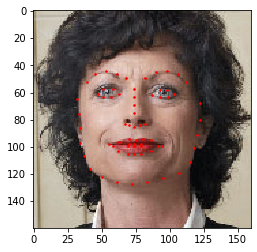

In [4]:
def show_landmarks(image, landmarks):
    "Show image with landmarks"
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker=".", c="r")
    plt.pause(0.001)  # pause a bit so that plots are updated
    
plt.figure()
show_landmarks(io.imread(os.path.join("../../datasets/faces/", img_name)), landmarks)
plt.show()


## Dataset类

torch.utils.data.Dataset为表示数据集的抽象类。Dataset类的子类需要重载：

* \_\_len__：len(dataset)返回数据集尺寸
* \_\_getitem__：支持索引操作dataset[i]

In [5]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1 :].as_matrix()
        landmarks = landmarks.astype(np.float).reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    


0 (324, 215, 3) (68, 2)


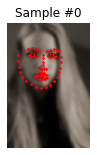

1 (500, 333, 3) (68, 2)


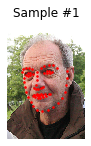

2 (250, 258, 3) (68, 2)


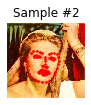

3 (434, 290, 3) (68, 2)


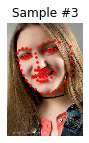

In [6]:
face_dataset = FaceLandmarksDataset(csv_file="../../datasets/faces/face_landmarks.csv",
                                    root_dir="../../datasets/faces/")

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample["image"].shape, sample["landmarks"].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title("Sample #{}".format(i))
    ax.axis("off")
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

## Transforms

* Rescale：缩放
* RandomCrop：随机裁剪
* ToTensor：numpy图像转torch图像

实现可调用类：\_\_call__()

In [7]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[: 2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image=image, output_shape=(new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {"image": img, "landmarks": landmarks}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[: 2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top : top + new_h, left : left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {"image": image, "landmarks": landmarks}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {"image": torch.from_numpy(image),
                "landmarks": torch.from_numpy(landmarks)}
    

### 组合变换

* torchvision.transforms.Compose

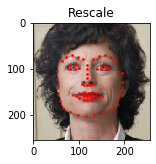

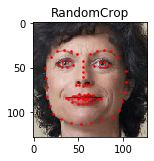

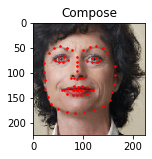

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

### 遍历数据集

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file="../../datasets/faces/face_landmarks.csv",
                                           root_dir="../../datasets/faces/",
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample["image"].size(), sample["landmarks"].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


* torch.utils.data.DataLoader

    * Batching the data
    * Shuffling the data
    * Load the data in parallel using multiprocessing workers
    
    

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


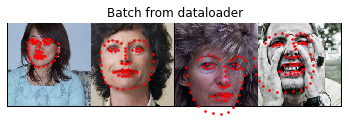

In [14]:
dataloader = DataLoader(dataset=transformed_dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
        sample_batched["image"], sample_batched["landmarks"]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker=".", c="r")
        
    plt.title("Batch from dataloader")
    
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched["image"].size(),
          sample_batched["landmarks"].size())
    
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis("off")
        plt.ioff()
        plt.show()
        break

### Afterword: torchvision

* ImageFolder

```python
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```

In [18]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

hymenoptera_dataset = datasets.ImageFolder(root="../../datasets/hymenoptera_data/train",
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(dataset=hymenoptera_dataset,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=4)